In [1]:
import pandas as pd
import numpy as np
import random
import datetime
from sklearn.preprocessing import normalize
from numpy.linalg import norm

from scipy.optimize import minimize
import matplotlib.pyplot as plt
from gurobipy import Model, LinExpr, GRB, quicksum
import pymc3 as pm

import warnings
warnings.filterwarnings("ignore")

import pickle

### Preliminary Algorithms

In [2]:
def subset_selection_Davis1(reward,utility,K,N):
    # r, u_i with len=N instead of N+1
    r = reward
    u_i = utility
    b = K           

    m = Model('Subset Selection')
    m.setParam('OutputFlag', 0) 

    w = list()      # probability of choosing {0} or items{1,...,N}
    for i in range(N+1):
        w.append(m.addVar(lb = 0, ub = 1, name = 'w_%i' % i))

    m.addConstr(quicksum(w[i] for i in range(1,N+1))+w[0], GRB.EQUAL, 1)
    m.addConstr(quicksum(w[i]/u_i[i-1] for i in range(1,N+1)) - b*w[0], GRB.LESS_EQUAL, 0)
    for i in range(1,N+1):
        m.addConstr(w[i]/u_i[i-1], GRB.GREATER_EQUAL, 0)
        m.addConstr(w[i]/u_i[i-1] - w[0], GRB.LESS_EQUAL, 0)

    m.setObjective(quicksum(w[i]*r[i-1] for i in range(1,N+1)), GRB.MAXIMIZE)

    m.update()            
    m.optimize()
    m.ObjVal
    x = m.getVars()

    items_offered = []
    for i in range(len(x)):
        if x[i].x>0:
            items_offered.append(x[i].varname)
    
    # items in the optimal assortment S_l, index start from 1!
    items_offered = [int(name[2:]) for name in items_offered]
    if items_offered[0]==0:
        items_offered = items_offered[1:]
    
    # check items_offered
    #print('check z: ',sum([r[i-1]*u_i[i-1]/(1+sum(u_i[i-1] for i in items_offered)) for i in items_offered]))
    return items_offered

### Use MCMC in Contextual Bandit
- Use samples instead of means and stds of samples(variational Bayes)
- Not sample for each time
    - 1. compare the difference of thetas' means, if bigger than 0.1, do a posterior sampling
    - 2. if t is a power of 2, do a posterior sampling
- Do multiple(20) samples one time, randomly choose one sample as the posterior sample of thetas for this round

I defined 2 vsariables in my `model`: one is `thetas`, the multivariate normal variable, which we want to infer from the posterior distribution. The other is `choice_Y`, which is a Multinomial variable, but it's an observed variable.

<html>
    <a href='https://docs.pymc.io/PyMC3_and_Theano.html'>Ref</a></html>

In [3]:
def posterior_sample_theta(observations,size,Xit):
    model = pm.Model()
    with model:
        mu = [0 for i in range(10)]                 
        stds = [1 for i in range(10)]                # mu=0, cov=0, stds=1

        cov = np.zeros((D,D))
        for i in range(D):
            cov[i][i]=stds[i]
        
        thetas = pm.MvNormal('thetas', mu=mu, cov=cov, shape=D)

        Vj = pm.math.exp(pm.math.dot(Xit,thetas))     # utility for product j
        V = 1 + pm.math.sum(Vj)                       # sum of utility(denominator), start with utility of not buying
        Vit = pm.math.concatenate([[1],Vj])           # utility of no purchase = 1

        choice_prob_it = Vit/V

        choice_Y = pm.Multinomial('Customer Choice',n=1, p=choice_prob_it, observed = observations)

    with model:
        step = pm.NUTS(target_accept=0.9)
        trace = pm.sample(size, step=step)
    
    theta_mus = pm.summary(trace)['mean'].values
    
    return trace['thetas'], theta_mus, trace

### TS-MNL Algorithms

In [4]:
def contextual_setting(t,fixed):
    
    if fixed:
        np.random.seed(800)

    else:
        np.random.seed(800+t)
    
    Xit = np.random.normal(0,1,size=(N,D-1))
    Xit = normalize(Xit, axis=1)
    Xit = np.append(Xit, [[1] for i in range(N)], axis=1)
    Xit = Xit/np.sqrt(2)
   
    return Xit

In [5]:
def Contextal_TS_MNL_Fixed(D,K,N,T,rit,Xit,true_theta,n_instance):
    
    v0 = 1
    v = np.exp(np.dot(Xit,theta_0))                  # initial utitlity, j=1, j=2, ... , j=N
    t = 0
    R = 0
    Optimal_R = 0

    initial_choice = [0 for i in range(N+1)]     # choice set, len=N+1
    initial_choice[0] = 1
    observations = [initial_choice]
    
    sample_round = 0
    theta_mu_track = [theta_0]
    reg_list = []
    
    while t<=T:

        # Posterior sampling
        """if t<2 or np.log2(t)%1==0:
            if t>5000:
                pass
            else:
                theta_i, theta_mu, trace = posterior_sample_theta(observations, posterior_size, Xit)
                theta_mu_track.append(theta_mu)
                print(t, theta_mu)
        elif t>300 and t<800:
            if abs(sum((theta_mu_track[-1] - theta_mu_track[-2])/theta_mu_track[-2]>0.1))>=1:
                theta_i, theta_mu, trace = posterior_sample_theta(observations, posterior_size, Xit)
                theta_mu_track.append(theta_mu)
                print(t, theta_mu)"""
        if t<=2000:
            theta_i, theta_mu, trace = posterior_sample_theta(observations, posterior_size, Xit)
            theta_mu_track.append(theta_mu)
            print(t, theta_mu)
    
        # 2 - Do 20 samples one time and randomly select 1 sample as theta: theta_i[np.random.randint(20)]
        
        # Assortment subset selection
        v = np.exp(np.dot(Xit,theta_i[np.random.randint(posterior_size*2)]))      # utility for this period t
        items_offered = subset_selection_Davis1(rit, v, K, N)       # items out of N
        items_list = np.insert(np.array(items_offered),0,0)         # items including no-purchase 0, len=N+1

        # Observe customer choice
        Xit_t = np.array([Xit[i-1] for i in items_offered])         # true v: choice probability for items showed
        true_v = np.exp(np.dot(Xit_t, true_theta)) 
        true_v = np.insert(true_v,0,v0)
        true_choice_prob = true_v/sum(true_v)

        true_choice_t = np.random.multinomial(1,true_choice_prob)   # len<=K, display
        choice_item = items_list[np.where(true_choice_t==1)[0][0]]
        choice_t = [0 for i in range(N+1)]
        choice_t[choice_item] = 1
        observations.append(choice_t)

        # Update reward
        if choice_item==0:
            R += 0
        else:
            R += rit[choice_item - 1]

        # Optimal reward:  instead of computing avg, calculate each time as features are changing
        optimal_v  = np.exp(np.dot(Xit, true_theta))                # optimal v: choice probability for all N items
        optimal_offered = subset_selection_Davis1(rit, optimal_v, K, N)
        optimal_list = np.insert(np.array(optimal_offered),0,0)

        optimal_Xit_t = np.array([Xit[i-1] for i in optimal_offered])
        optimal_true_v = np.exp(np.dot(optimal_Xit_t, true_theta)) 
        optimal_true_v = np.insert(optimal_true_v,0,v0)

        optimal_choice_prob = optimal_true_v/sum(optimal_true_v)
        optimal_choice = np.random.multinomial(1,optimal_choice_prob)

        optimal_choice_item = optimal_list[np.where(optimal_choice==1)[0][0]]

        # Update Optimal reward
        if optimal_choice_item==0:
            Optimal_R += 0
        else:
            Optimal_R += rit[optimal_choice_item - 1]
        
        #theta_mu_track.append(mus)
        t += 1 
        #print(t)
        
        reg = Optimal_R-R
        reg_list.append(reg)
    
    with open(f'TSMNL_regrets/TSMNL_regret_T{T}_0824_fixed{n_instance}.pkl', 'wb') as f:
            pickle.dump(reg_list,f)    
    
    with open(f'TSMNL_regrets/theta_mu_track_T{T}_0824_fixed{n_instance}.pkl', 'wb') as f:
            pickle.dump(theta_mu_track,f)
        
    return reg_list, theta_mu_track, trace

In [6]:
def Contextal_TS_MNL_TimeChanging(D,K,N,T,rit,true_theta,n_instance):
    
    v0 = 1
    t = 0
    R = 0
    Optimal_R = 0

    initial_choice = [0 for i in range(N+1)]     # choice set, len=N+1
    initial_choice[0] = 1
    observations = [initial_choice]
    
    sample_round = 0
    theta_mu_track = []
    reg_list = []
    
    while t<=T:

        # Posterior sampling
        # time-changing features:  Observe features
        Xit = contextual_setting(t,False)
        
        if t<2 or np.log2(t)%1==0:
            if t>5000:
                pass
            else:
                theta_i, theta_mu, trace = posterior_sample_theta(observations, posterior_size, Xit)
                theta_mu_track.append(theta_mu)
                print(t, theta_mu)
        elif t>300 and t<800:
            if abs(sum((theta_mu_track[-1] - theta_mu_track[-2])/theta_mu_track[-2]>0.1))>=1:
                theta_i, theta_mu, trace = posterior_sample_theta(observations, posterior_size, Xit)
                theta_mu_track.append(theta_mu)
                print(t, theta_mu)
        # 2 - Do 20 samples one time and randomly select 1 sample as theta: theta_i[np.random.randint(20)]
        
        # Assortment subset selection
        v = np.exp(np.dot(Xit,theta_i[np.random.randint(posterior_size*2)]))      # utility for this period t
        items_offered = subset_selection_Davis1(rit, v, K, N)       # items out of N
        items_list = np.insert(np.array(items_offered),0,0)         # items including no-purchase 0, len=N+1

        # Observe customer choice
        Xit_t = np.array([Xit[i-1] for i in items_offered])         # true v: choice probability for items showed
        true_v = np.exp(np.dot(Xit_t, true_theta)) 
        true_v = np.insert(true_v,0,v0)
        true_choice_prob = true_v/sum(true_v)

        true_choice_t = np.random.multinomial(1,true_choice_prob)   # len<=K, display
        choice_item = items_list[np.where(true_choice_t==1)[0][0]]
        choice_t = [0 for i in range(N+1)]
        choice_t[choice_item] = 1
        observations.append(choice_t)

        # Update reward
        if choice_item==0:
            R += 0
        else:
            R += rit[choice_item - 1]

        # Optimal reward:  instead of computing avg, calculate each time as features are changing
        optimal_v  = np.exp(np.dot(Xit, true_theta))                # optimal v: choice probability for all N items
        optimal_offered = subset_selection_Davis1(rit, optimal_v, K, N)
        optimal_list = np.insert(np.array(optimal_offered),0,0)

        optimal_Xit_t = np.array([Xit[i-1] for i in optimal_offered])
        optimal_true_v = np.exp(np.dot(optimal_Xit_t, true_theta)) 
        optimal_true_v = np.insert(optimal_true_v,0,v0)

        optimal_choice_prob = optimal_true_v/sum(optimal_true_v)
        optimal_choice = np.random.multinomial(1,optimal_choice_prob)

        optimal_choice_item = optimal_list[np.where(optimal_choice==1)[0][0]]

        # Update Optimal reward
        if optimal_choice_item==0:
            Optimal_R += 0
        else:
            Optimal_R += rit[optimal_choice_item - 1]
        
        #theta_mu_track.append(mus)
        t += 1 
        #print(t)
        
        reg = Optimal_R-R
        reg_list.append(reg)
        
    with open(f'TSMNL_regrets/TSMNL_regret_T{T}_0823_Changing{n_instance}.pkl', 'wb') as f:
            pickle.dump(reg_list,f)    

    with open(f'TSMNL_regrets/theta_mu_track_T{T}_0823_Changing{n_instance}.pkl', 'wb') as f:
            pickle.dump(theta_mu_track,f)
        
    return reg_list, theta_mu_track, trace

In [7]:
def plot_regret_trace(T_str,ninstance_str,date_str,Fixed_Changing_str):
    import pickle
    with open(f'TSMNL_regrets/TSMNL_regret_T{T_str}_{date_str}_{Fixed_Changing_str}{ninstance_str}.pkl', 'rb') as f:
        x = pickle.load(f)
    plt.figure(figsize=(8,6))
    plt.plot(x, c="green")
    plt.title(f"{Fixed_Changing_str} features: TS-MNL with MCMC Sampling", fontsize=14)
    plt.xlabel("Periods: T")
    plt.ylabel("Regrets")
    plt.show()

    with open(f'TSMNL_regrets/theta_mu_track_T{T_str}_{date_str}_{Fixed_Changing_str}{ninstance_str}.pkl', 'rb') as f:
        theta_mu_track = pickle.load(f)
    plt.figure(figsize=(8,6))
    plt.plot(theta_mu_track)
    plt.title('Track the mean of sampled thetas')
    plt.xlabel('Sample rounds')
    plt.ylabel('Mean of thetas')
    plt.show()

### 1. Contextual Setting 1: time-fixed product features and rewards

In [8]:
import pickle
import numpy as np
x=[]
for i in range(5):
    with open(f'TSMNL_regrets/TSMNL_regret_T10000_0823_Fixed{i}.pkl', 'rb') as f:
        x.append(pickle.load(f))

x = np.array([np.array(i) for i in x])

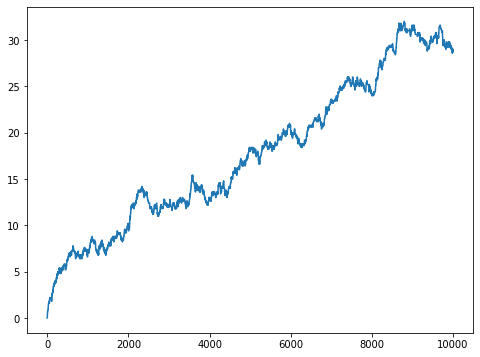

In [9]:
plt.figure(figsize=(8,6))
plt.plot(np.mean(x,axis=0))

In [ ]:
D = 10
N = 128
K = 8
T = 10000
posterior_size = 20

rit = np.array([1 for i in range(N)])

np.random.seed(800)
theta_0 = np.random.normal(0,1,D)
np.random.seed(800)
true_theta = np.random.normal(0,1,D)
Xit = contextual_setting(0,True)
print(true_theta,Xit)

regret_fixed = []
theta_mu_track_fixed = []
trace_fixed = []
for i in range(10):
    x, y, z = Contextal_TS_MNL_Fixed(D,K,N,T,rit,Xit,true_theta,i)
    regret_fixed.append(x)
    theta_mu_track_fixed.append(y)
    trace_fixed.append(z)

[-0.20034586 -0.72274961 -1.00643648 -0.43536761  0.93033648 -0.69471352
 -3.29189218 -0.6389869   0.11438877  0.20406986] [[-0.03736982 -0.13481197 -0.18772709 ... -0.119188    0.02133654
   0.70710678]
 [ 0.07217456 -0.26551363  0.05999602 ...  0.08510846 -0.52867239
   0.70710678]
 [-0.40565247  0.238807   -0.10170313 ...  0.11184398  0.10368141
   0.70710678]
 ...
 [-0.26799584  0.11790492 -0.07990202 ... -0.05045935 -0.26117488
   0.70710678]
 [-0.07637925 -0.40620153 -0.30409797 ... -0.11016237 -0.02568183
   0.70710678]
 [-0.04691193  0.0678582   0.0823647  ...  0.08609482 -0.37184851
   0.70710678]]


Only 20 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [thetas]
INFO:pymc3:NUTS: [thetas]


In [ ]:
for i in range(5):
    plot_regret_trace('10000',str(i),'0822','Fixed')

### 2. Contextual Setting 2: time-changing product features and rewards

##### Alg1: TS-MNL with mcmc

In [ ]:
D = 10
N = 128
K = 8
T = 10000
posterior_size = 1000

rit = np.array([1 for i in range(N)])

np.random.seed(800)
true_theta = np.random.normal(0,1,D)
Xit = contextual_setting(0,True)
print(true_theta,Xit)

regret_changing = []
theta_mu_track_changing = []
trace_changing = []
for i in range(5):
    x, y, z = Contextal_TS_MNL_TimeChanging(D,K,N,T,rit,true_theta,i)
    regret_changing.append(x)
    theta_mu_track_changing.append(y)
    trace_changing.append(z)

In [ ]:
plot_regret_trace('10000',0,'0822','Changing')